# Model Evaluation

Model evaluation is done by splitting the available data into three sets: training data, validation data and test data. Training data is used to train the model; validation data is used to find the best configuration parameters (hyperparameters) of the model; and the test data is used to evaluate the generalizability of the model.

We consider three classic evaluation recipes: 

* simple hold-out validation
* $K$-fold validation, and 
* iterated $K$-fold validation with shuffling.

## Simple Hold-Out Validation

In [1]:
import numpy as np
from typing import List, Tuple


def train_val_split(data: np.array, val_set_frac: float) -> Tuple[np.array, np.array]:
    assert val_set_frac >= 0 and val_set_frac <= 1
    
    local_cpy = np.copy(data)
    np.random.shuffle(local_cpy)
    
    idx = int(len(local_cpy) * val_set_frac)
    val_data = local_cpy[: idx]
    train_data = local_cpy[idx :]
    
    return train_data, val_data

One tests a set of models with different configurations (hyperparameters) and chooses the best configuration.

```python
scores = []
for model_config in list_of_configurations:
    model = get_model(model_config)
    train, val = train_val_split(training_data)
    model.fit(train)
    scores.append(model.evaluate(val))
```

Then the chosen model is evaluated with the test data.
```python
model = get_model(chosen_config)                                        
model.train(training_data)             
test_score = model.evaluate(test_data) 
```

## $K$-Fold Cross Validation

Partition the dataset into $K$ sets of roughly equal size. For $1 \leq i \leq K$, do the following: train on $K - 1$ partitions and evaluate on the $i$th partition and keep a track of the score. The final score of the model is the average of the scores in each of these iterations. 

In [2]:
from typing import Dict, Any


def k_fold_crossvalidation(data: np.array, k: int, model_configuration: Dict[Any, Any]) -> float:
    assert k > 1
    
    num_validation_samples = len(data) // k

    np.random.shuffle(data)

    validation_scores = []
    
    for fold in range(k):
        validation_data = data[num_validation_samples * fold: num_validation_samples * (fold + 1)] 
        training_data = np.concatenate(data[:num_validation_samples * fold], 
                                       data[num_validation_samples * (fold + 1):], axis=0)
        model = get_model(model_configuration)
        model.train(training_data)
        validation_score = model.evaluate(validation_data)
        validation_scores.append(validation_score)

    return np.average(validation_scores)  

One we have evaluated models with different configurations, we select the configuration that is best and then evaluate the model on the test data.

```python
model = get_model(final_configuration)                                                   
model.train(data)                                                     
test_score = model.evaluate(test_data)  
```

# Data Preprocessing

One cannot directly feed raw data to a neural network in most situations. Raw data needs to be processed and typical procesing steps include _vectorization_, _normalization_, _handling missing values_ and _feature extraction_. 

### Data Vectorization

All inputs to a neural network must be in the form of tensors of floating point data. Whatever the raw data, be it text, sound or images, must be first transformed into tensors. 

### Data Normalization

In general, it is not a good idea to feed a neural network numbers that are very large compared to the initial weights with which the network is initialized or data that is very heterogeneous (data where different features vary over widely different ranges). Large numbers can cause the output of the neurons to take on very large or very small values. This, in turn, makes it difficult to update the gradient of the activation function of those neurons leading to slow convergence.

Simple rule of thumb:

* Values should be in the 0-1 range
* Features should be homogeneous in the sense of having values in the same range

Simple normalization practice

* Normalize each feature independently to have a mean of $0$
* Normalize each feature independently to have a standard deviation of $1$

## IMDB Classification Using Different Models

In [3]:
from keras.datasets import imdb

# num_words = 10000 keeps the 10000 most frequently occurring words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

/home/somnath/install/anaconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/somnath/install/anaconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
# Labels are either 0 or 1: 0 stands for a negative review and 1 for a positive review
train_labels[0:4]

array([1, 0, 0, 1])

In [6]:
max([max(s) for s in train_data])

9999

In [7]:
# decoding labels to words

word_index = imdb.get_word_index()                 

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])            

# The first three word indices 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [8]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### Encoding Data

In [9]:
import numpy as np

from typing import List

def vectorize_sequences(sequences: List[List[int]], dimension=10000):
    results = np.zeros((len(sequences), dimension))        
    
    for i, sequence in enumerate(sequences):
        # type(sequence) = List[int]
        results[i, sequence] = 1.                          
    return results

x_train = vectorize_sequences(train_data)                  
x_test = vectorize_sequences(test_data)   

In [10]:
x_train.shape

(25000, 10000)

In [11]:
train_labels.shape

(25000,)

In [12]:
type(train_labels)

numpy.ndarray

In [13]:
# Vectorize labels, though not sure that this is necessary

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [14]:
type(y_train)

numpy.ndarray

### First Model

In [15]:
from keras import models
from keras import layers

def build_model(layer_sizes, layer_activations, input_shape=10000):
    model = models.Sequential()
    model.add(layers.Dense(layer_sizes[0], 
                           activation=layer_activations[0], 
                           input_shape=(input_shape,)))
    
    for i, sz in enumerate(layer_sizes[1:]): 
        model.add(layers.Dense(sz, 
                               activation=layer_activations[i]))
    
    return model

In [16]:
model1 = build_model([16, 16, 1], ['relu', 'relu', 'sigmoid'])

### Compile Model

In [17]:
model1.compile(optimizer='rmsprop', 
               loss='binary_crossentropy', 
               metrics=['accuracy'])

### Validation Set

In [18]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

### Train

In [19]:
history1 = model1.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 49ms/step - loss: 0.7804 - accuracy: 0.6381 - val_loss: 0.4537 - val_accuracy: 0.7955
Epoch 2/20
30/30 [==============================] - 1s 41ms/step - loss: 0.3658 - accuracy: 0.8569 - val_loss: 0.3858 - val_accuracy: 0.8586
Epoch 3/20
30/30 [==============================] - 1s 35ms/step - loss: 0.2632 - accuracy: 0.9086 - val_loss: 0.4413 - val_accuracy: 0.8746
Epoch 4/20
30/30 [==============================] - 1s 42ms/step - loss: 0.2229 - accuracy: 0.9265 - val_loss: 0.4707 - val_accuracy: 0.8795
Epoch 5/20
30/30 [==============================] - 1s 41ms/step - loss: 0.1760 - accuracy: 0.9505 - val_loss: 0.5252 - val_accuracy: 0.8864
Epoch 6/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1552 - accuracy: 0.9588 - val_loss: 0.6092 - val_accuracy: 0.8849
Epoch 7/20
30/30 [==============================] - 1s 40ms/step - loss: 0.1330 - accuracy: 0.9701 - val_loss: 0.7565 - val_accuracy: 0.8724
Epoch 8/20
30

In [20]:
hist_dict1 = history1.history
hist_dict1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
hist_dict1['loss']

[0.7804002165794373,
 0.3657699525356293,
 0.2632185220718384,
 0.22287529706954956,
 0.17595994472503662,
 0.15521253645420074,
 0.13304737210273743,
 0.1123143807053566,
 0.09926082193851471,
 0.092044897377491,
 0.07721783220767975,
 0.08871104568243027,
 0.06824624538421631,
 0.058288976550102234,
 0.0755770355463028,
 0.05421750247478485,
 0.07121636718511581,
 0.05336262285709381,
 0.0708073303103447,
 0.051912736147642136]

## Plots

In [22]:
import matplotlib.pyplot as plt

def plot_training_validation_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')           
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')      
    
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_training_validation_accuracy(history):               
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

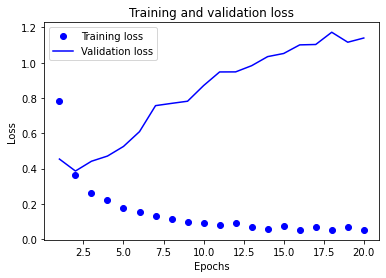

In [23]:
plot_training_validation_loss(history1)

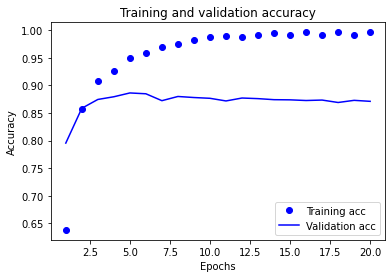

In [24]:
plot_training_validation_accuracy(history1)